# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = format(X_train[0].shape)

# TODO: How many unique classes/labels there are in the dataset.
from numpy import recfromcsv
class_data = recfromcsv('signnames.csv', delimiter=',')

n_classes = len(class_data)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pprint import pprint
import matplotlib.gridspec as gridspec
from collections import defaultdict
from random import randint
from sklearn.utils import shuffle
import tensorflow as tf
from skimage import exposure
from skimage.color import rgb2gray

# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:

#This transform_image code was originally written by of udacity member vivek
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''    
    
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img  

def applyColorAdjustments(img):
    img = tf.image.random_brightness(img, max_delta=63)
    img = tf.image.random_contrast(img, lower=0.2, upper=1.8)
    return img

def hisEqualColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
    channels=cv2.split(ycrcb)
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2RGB,img)
    return img

def fillTrainingSet(index,number,listTrainingIndexes):
    x = []
    y = []
    
    randomIndex = listTrainingIndexes[randint(0,10)]
    #get a random sample sign image of this index
    image = X_train[randomIndex]
    
    for i in range(number):
        #transform image
        img = transform_image(image,20,10,5)
        #add to X_train and y_train
        x.append(img)
        y.append(index)
    return x,y
        
def plotImageByIndex(index):
    plt.suptitle(class_data[y_train[index]])
    plt.imshow(X_train[index])
    
def showImageGrid(images,x,y,labels = []):
    gs1 = gridspec.GridSpec(x, y)
    #gs1.update(wspace=0.00, hspace=0.00) # set the spacing between axes. 
    plt.figure(figsize=(8,8))
    for i in range(len(images)):
        ax1 = plt.subplot(gs1[i])
        if len(labels) == len(images):
            print(labels[i])
            ax1.set_title(labels[i])
        plt.subplot(x,y,i+1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()

Original distribution of classes:
{0: 210, 1: 2220, 2: 2250, 3: 1410, 4: 1980, 5: 1860, 6: 420, 7: 1440, 8: 1410, 9: 1470, 10: 2010, 11: 1320, 12: 2100, 13: 2160, 14: 780, 15: 630, 16: 420, 17: 1110, 18: 1200, 19: 210, 20: 360, 21: 330, 22: 390, 23: 510, 24: 270, 25: 1500, 26: 600, 27: 240, 28: 540, 29: 270, 30: 450, 31: 780, 32: 240, 33: 689, 34: 420, 35: 1200, 36: 390, 37: 210, 38: 2070, 39: 300, 40: 360, 41: 240, 42: 240}
Maximum number of values on a class:  2250
Minimum number of values on a class:  210


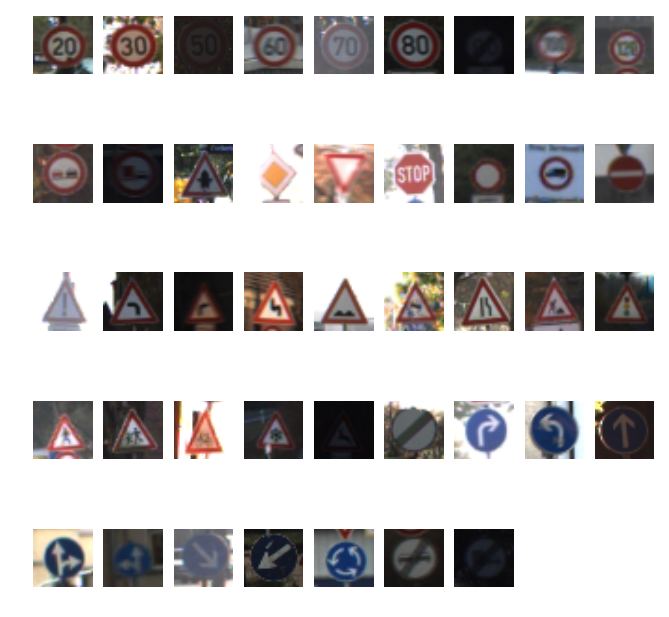

In [5]:
def generateCountMap():
    countMap = defaultdict(list)
    for i in range(len(X_train)):
        index = y_train[i] 
        countMap[index].append(i)
    return countMap

def generateValueCountMap(countMap):
    valueCountMap = dict.fromkeys(list(range(n_classes)),list())
    for i in range(n_classes):
        valueCountMap[i] = len(countMap[i])
    return valueCountMap

def printClassSamples(minValue):
    #print all classes once
    each_class_sample = [item[randint(0,minValue)] for item in countMap.values()]
    sample_images = []
    sample_labels = []
    count = 0
    for sample in each_class_sample:
        sample_images.append(X_train[sample])
        #sample_labels.append(class_data[count])
        count += 2
    showImageGrid(sample_images,5,9, sample_labels)

countMap = generateCountMap()
valueCountMap = generateValueCountMap(countMap)

print('Original distribution of classes:')
print(valueCountMap)
#distribution shows inbalanced data, so generate equal data for all signs
maxValue = max(valueCountMap.values())
print('Maximum number of values on a class: ', maxValue)
minValue = min(valueCountMap.values())
print('Minimum number of values on a class: ', minValue)

printClassSamples(minValue)
#So maxValue will be the total number of labeled data generated for all others which have less

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Preprocess Data

In [6]:
def batch_norm(x, ptrain, scope=None):
    with tf.variable_scope('bn'):
        batch_norm = tf.cond(ptrain, 
        lambda: tf.contrib.layers.batch_norm(x, activation_fn=tf.nn.relu, updates_collections=None, is_training=True, reuse=None, scope=scope),
        lambda: tf.contrib.layers.batch_norm(x, activation_fn =tf.nn.relu, updates_collections=None, is_training=False, reuse=True, scope=scope))
        return batch_norm

### Generate data additional data (OPTIONAL!)
#for each class add the number of missing labeled data up to maxValue by generating new transformed images 
#of existing labeled data, so that from each class exists the same number of samples
addJitterData = True

#Fill up missing values
if addJitterData:
    for i in range(0,n_classes):
        missing = np.absolute(valueCountMap[i] - maxValue)
        #print('Generating missing values for sign index ', i, ' = ', missing)
        x,y = fillTrainingSet(i,missing,countMap[i])
        if len(x) == 0:
            continue
        X_train = np.concatenate((X_train,x))
        y_train = np.concatenate((y_train,y))
            
    #Also add from each class type another num generated jittered images
    countMap = generateCountMap()
    valueCountMap = generateValueCountMap(countMap)

    num = 750
    for i in range(n_classes):
        x,y = fillTrainingSet(i,num,countMap[i])
        X_train = np.concatenate((X_train,x))
        y_train = np.concatenate((y_train,y))
    
    countMap = generateCountMap()
    valueCountMap = generateValueCountMap(countMap)
    print(valueCountMap)
    
#Do random image brightness and contrast adjustments
#TODO

#Do 0-1 normalization, validation set is already normalized as will be splitted from X_train
X_train = X_train / 255.0
X_test = X_test / 255.0

{0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000, 6: 3000, 7: 3000, 8: 3000, 9: 3000, 10: 3000, 11: 3000, 12: 3000, 13: 3000, 14: 3000, 15: 3000, 16: 3000, 17: 3000, 18: 3000, 19: 3000, 20: 3000, 21: 3000, 22: 3000, 23: 3000, 24: 3000, 25: 3000, 26: 3000, 27: 3000, 28: 3000, 29: 3000, 30: 3000, 31: 3000, 32: 3000, 33: 3000, 34: 3000, 35: 3000, 36: 3000, 37: 3000, 38: 3000, 39: 3000, 40: 3000, 41: 3000, 42: 3000}


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Data has been 0-1 normalized to scale the input vectors. 

In [7]:
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   103200 samples
Validation Set: 25800 samples
Test Set:       12630 samples


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I created jittered data as it turned out on checking the class distribution of the original dataset, that it's heavily unbalanced. So i first generated an equal number of all classes and than much more samples to train on.

The validation set has been splitted from the test set with a factor of 0.2.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    print_activations(x)
    x = tf.nn.bias_add(x, b)
    print_activations(x)
    return x

def activate(x, atype = 'relu', scope=None):
    temp = x
    if atype == 'relu':
        temp = tf.nn.relu(x, name=scope.name)
    elif atype == 'tanh':
        temp = tf.nn.tanh(x, name=scope.name)
        
    print_activations(temp)
    return temp

def maxpool2d(x, k=2):
    temp = tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')
    print_activations(temp)
    return temp

def dropout(hidden_layer, keep_prob = 0.5):
    if True:
        return hidden_layer
    temp = tf.nn.dropout(hidden_layer, keep_prob)
    print_activations(hidden_layer)
    return temp

def print_activations(temp, do=True):
    if do:
        print(temp.op.name, ' ', temp.get_shape().as_list())
    

def training(loss, learning_rate, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_operation = optimizer.minimize(loss, global_step=global_step)
    return training_operation

def evaluation(y_pred, one_hot_y):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(one_hot_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def LeNet(x,ptrain, keep_prob, weights, biases):    
    
    with tf.variable_scope('conv_1') as scope:
        # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x8.
        conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])

        #Batch norm
        #conv1 = batch_norm(conv1, ptrain, scope)

        # Activation.
        conv1 = activate(conv1, 'relu', scope)

        # Pooling. Input = 30x30x8. Output = 15x15x8.
        conv1 = maxpool2d(conv1)

        conv1 = dropout(conv1, keep_prob)

    with tf.variable_scope('conv_2') as scope:
        # Layer 2: Convolutional. Input = 15x15x8 Output = 11x11x16.
        conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])

        #Batch norm
        #conv2 = batch_norm(conv2, ptrain, scope)

        # Activation.
        conv2 = activate(conv2, 'relu', scope)

        # Pooling. Input = 11x11x16. Output = 5x5x16.
        conv2 = maxpool2d(conv2)

        conv2 = dropout(conv2, keep_prob)
    
        # Flatten. Input = 5x5x16. Output = 400.
        flatten_1 = flatten(conv2)
    
    with tf.variable_scope('fc_1') as scope:
        # Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1 = tf.reshape(flatten_1,[-1, weights['fully_connected_1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['fully_connected_1']),biases['fully_connected_1'])
        fc1 = activate(fc1, 'tanh', scope)

        # Activation.
        fc1 = activate(fc1, 'relu', scope)

        fc1 = dropout(fc1, keep_prob)
    
    with tf.variable_scope('fc_2') as scope:
        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2 = tf.reshape(fc1,[-1, weights['fully_connected_2'].get_shape().as_list()[0]])
        fc2 = tf.add(tf.matmul(fc2, weights['fully_connected_2']),biases['fully_connected_2'])
        fc2 = activate(fc2, 'tanh', scope)

        # Activation.
        fc2 = activate(fc2, 'relu', scope)

        fc2 = dropout(fc2, keep_prob)

    with tf.variable_scope('fc_3') as scope:
        # Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3 = tf.reshape(fc2,[-1, weights['fully_connected_3'].get_shape().as_list()[0]])
        fc3 = tf.add(tf.matmul(fc3, weights['fully_connected_3']),biases['fully_connected_3'])

        # Read out
        y_pred = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
   
    print_activations(y_pred)
    
    return y_pred

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

## Using modified LeNet-5
[LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

### Architecture
**Layer 1: Convolutional.** 30, 30, 8

**Batch normalization.** 30, 30, 8

**Activation.**  30, 30, 8

**Pooling.** 15, 15, 8

**Dropout.** 11, 11, 16

**Layer 2: Convolutional.** 11, 11, 16

**Batch normalization.** 11, 11, 16

**Activation.** 11, 11, 16

**Pooling.** 5, 5, 16

**Dropout.** 5, 5, 16

**Flatten.** 400

**Layer 3: Fully Connected.** 120

**Activation.** 120

**Dropout.** 120

**Layer 4: Fully Connected.** 84

**Activation.** 84

**Dropout.** 84

**Layer 5: Fully Connected (Logits).** 43

In [9]:
import os

# Hyperparameters
mu = 0
sigma = 0.1

n_classes = 43

layer_depth = {
    'layer_1': 8,
    'layer_2': 16,
    'fully_connected_1': 120,
    'fully_connected_2': 84,
    'fully_connected_3': 43
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [3, 3, 3, layer_depth['layer_1']], mean = mu, stddev = sigma)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mean = mu, stddev = sigma)),
    'fully_connected_1': tf.Variable(tf.truncated_normal(
        [400, layer_depth['fully_connected_1']], mean = mu, stddev = sigma)),
    'fully_connected_2': tf.Variable(tf.truncated_normal(
        [120, layer_depth['fully_connected_2']], mean = mu, stddev = sigma)),
    'fully_connected_3': tf.Variable(tf.truncated_normal(
        [84, layer_depth['fully_connected_3']], mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_3'], n_classes], mean = mu, stddev = sigma))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'fully_connected_3': tf.Variable(tf.zeros(layer_depth['fully_connected_3'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

### Train your model here.
TASK = 'train' # 'train' or 'test'
chkpt_file = '../my_cnn.ckpt'

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
ptrain = tf.placeholder(tf.bool, name='train')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

l2_beta=0.001
threshold=0.98

EPOCHS = 15
BATCH_SIZE = 64

epoch_size = 250000
global_step = tf.Variable(0, name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(
  0.001,                # Base learning rate.
  global_step * BATCH_SIZE,  # Current index into the dataset.
  epoch_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)

y_pred = LeNet(x,ptrain,keep_prob, weights, biases)

 # Get Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_pred, one_hot_y)
loss = tf.reduce_mean(cross_entropy)

# Add l2 regularization to the loss
for key in list(weights.keys()):
    loss += l2_beta * tf.nn.l2_loss(weights[key])

# Update
train_step = training(loss, learning_rate, global_step)

# Eval
accuracy = evaluation(y_pred, one_hot_y)

vars_to_train = tf.trainable_variables()
vars_for_bn1 = tf.get_collection(tf.GraphKeys.VARIABLES, scope='conv_1/bn')
vars_for_bn2 = tf.get_collection(tf.GraphKeys.VARIABLES, scope='conv_2/bn')
vars_to_train = list(set(vars_to_train).union(set(vars_for_bn1)))
vars_to_train = list(set(vars_to_train).union(set(vars_for_bn2)))

if TASK == 'test' and os.path.exists(chkpt_file):
    restore_call = True
    vars_all = tf.all_variables()
    vars_to_init = list(set(vars_all) - set(vars_to_train))
    init = tf.initialize_variables(vars_to_init)
elif TASK == 'train':
    restore_call = False
    init = tf.initialize_all_variables()
else:
    print('please set TASK to either train or test')

saver = tf.train.Saver(vars_to_train)

conv_1/Conv2D   [None, 30, 30, 8]
conv_1/BiasAdd   [None, 30, 30, 8]
conv_1/conv_1   [None, 30, 30, 8]
conv_1/MaxPool   [None, 15, 15, 8]
conv_2/Conv2D   [None, 11, 11, 16]
conv_2/BiasAdd   [None, 11, 11, 16]
conv_2/conv_2   [None, 11, 11, 16]
conv_2/MaxPool   [None, 5, 5, 16]
fc_1/fc_1   [None, 120]
fc_1/fc_1_1   [None, 120]
fc_2/fc_2   [None, 84]
fc_2/fc_2_1   [None, 84]
fc_3/Add_1   [None, 43]


In [10]:
with tf.device('/gpu:0'):
    with tf.Session() as sess:
        sess.run(init)

        if restore_call:
            # Restore variables from disk.
            saver.restore(sess, chkpt_file) 

        if TASK == 'train':
            #sess.run(tf.global_variables_initializer())
            num_examples = len(X_train)

            print("Training on ", num_examples, ' examples')
            print()
            lastAccuracy = 0
            
            for i in range(EPOCHS):
                X_train, y_train = shuffle(X_train, y_train)
                
                if threshold < lastAccuracy:
                    print('Stopping training, threshold accuracy of ', threshold, ' reached!') 
                    break;

                for offset in range(0, num_examples, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(train_step, feed_dict={x: batch_x, y: batch_y, ptrain: True, keep_prob: 0.5})

                    if offset % num_examples/BATCH_SIZE == 0:
                        cv_fd = {x: X_validation, y: y_validation, ptrain: False, keep_prob: 1.0}
                        train_loss = loss.eval(cv_fd)
                        train_accuracy = accuracy.eval(cv_fd)
                        print('Learning Rate:', learning_rate.eval(), ', Global Step: ', global_step.eval())
                        print('EPOCH {}'.format(i+1),', Loss: %8.4f, Validation Accuracy = %8.4f' % (train_loss, train_accuracy))
                        lastAccuracy = train_accuracy
            save_path = saver.save(sess, chkpt_file)
            print("Model saved in file: %s" % save_path)

        #Test
        test_fd = {x: X_test, y: y_test, ptrain: False, keep_prob: 1.0}
        print("Test Accuracy = {:.3f}".format(accuracy.eval(test_fd)))

Training on  103200  examples

0.98  vs  0
Learning Rate: 0.001 , Global Step:  1
EPOCH 1 , Loss:   4.0181, Validation Accuracy =   0.0213
0.98  vs  0.0213178
Learning Rate: 0.001 , Global Step:  1614
EPOCH 2 , Loss:   0.8358, Validation Accuracy =   0.8381
0.98  vs  0.838062
Learning Rate: 0.001 , Global Step:  3227
EPOCH 3 , Loss:   0.5479, Validation Accuracy =   0.9284
0.98  vs  0.928411
Learning Rate: 0.00095 , Global Step:  4840
EPOCH 4 , Loss:   0.4529, Validation Accuracy =   0.9568
0.98  vs  0.956822
Learning Rate: 0.00095 , Global Step:  6453
EPOCH 5 , Loss:   0.3938, Validation Accuracy =   0.9716
0.98  vs  0.97155
Learning Rate: 0.0009025 , Global Step:  8066
EPOCH 6 , Loss:   0.3703, Validation Accuracy =   0.9744
0.98  vs  0.97438
Learning Rate: 0.0009025 , Global Step:  9679
EPOCH 7 , Loss:   0.3445, Validation Accuracy =   0.9789
0.98  vs  0.978876
Learning Rate: 0.0009025 , Global Step:  11292
EPOCH 8 , Loss:   0.3531, Validation Accuracy =   0.9757
0.98  vs  0.975698


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Best fit currently are 10 Epochs with a batch size of 128. There mostly the accuracy converges between epoch 8 and 10.
As starter learning rate 0.001 is chosen, all others resolve in a huge decrease on accuracy.
The learning rate is decayed by 0.9.

The training set is shuffled per epoch.

The probability errors are measured with softmax_cross_entropy_with_logits. and the loss is L2 regularized.
As optimizer the SDG variant Adam has been chosen as it was on the LeNet implementation of the lessons.

mean of 0 and a stddev of 0.1 as recommended in the lessons papers.

Dropouts have been attached to all but the last layer with a keep_prob of 0.5 but has been disabled as it did decrease results.

Early stopping is applied after reaching a training threshold.

Example runs:
Validation Accuracy =   0.9830, Test Accuracy = 0.863


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The starting point was the LeNet architecture from the lessons which already gave about 90% validation accuracy but only 56% test accuracy. So i went on to find out the cause by starting from the top on data preprocessing. 

I balanced out the test data with jittered images which did not really improve the results that much, at least not on the current params.

after a mentor talk, I applied 0-1 normalization. which lifted the validation accuracy to 97% but still bad test accuracy of 70%. Also the fixed learning rate was turned into an exponential decay to decrease the learning rate step by step. So 98,4% of validation accuracy was achieved,  with about 88% test accuracy.

Other techniques tried besides maxpooling and activation like relu, tanh, were 
- dropout
- batch_normalization




---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

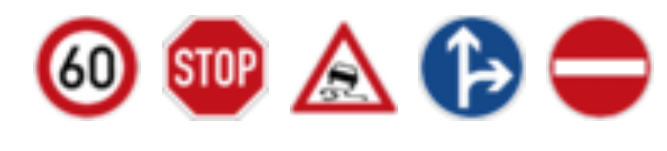

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
'''
ClassId	SignName
0	Speed limit (20km/h)
1	Speed limit (30km/h)
2	Speed limit (50km/h)
3	Speed limit (60km/h)
4	Speed limit (70km/h)
5	Speed limit (80km/h)
6	End of speed limit (80km/h)
7	Speed limit (100km/h)
8	Speed limit (120km/h)
9	No passing
10	No passing for vechiles over 3.5 metric tons
11	Right-of-way at the next intersection
12	Priority road
13	Yield
14	Stop
15	No vechiles
16	Vechiles over 3.5 metric tons prohibited
17	No entry
18	General caution
19	Dangerous curve to the left
20	Dangerous curve to the right
21	Double curve
22	Bumpy road
23	Slippery road
24	Road narrows on the right
25	Road work
26	Traffic signals
27	Pedestrians
28	Children crossing
29	Bicycles crossing
30	Beware of ice/snow
31	Wild animals crossing
32	End of all speed and passing limits
33	Turn right ahead
34	Turn left ahead
35	Ahead only
36	Go straight or right
37	Go straight or left
38	Keep right
39	Keep left
40	Roundabout mandatory
41	End of no passing
42	End of no passing by vechiles over 3.5 metric tons
'''

def readNewImages(filenames):
    images = []
    for name in filenames:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

y_new = np.array([3,14,23,36,17
                  #,1,2,29,27,50,50
                 ])
filenames = ["new/274.png","new/206.png","new/114.png","new/214.png","new/267.png"
#,"new/30.png","new/50.png","new/cycle.png","new/pedestrians.png","new/ducks.png","new/snow.png"
             ]
X_new = readNewImages(filenames)
showImageGrid(X_new,3,5)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, chkpt_file)
    
    test_fd = {x: X_new, y: y_new, ptrain: False, keep_prob: 1.0}
    print("New Accuracy = {:.3f}".format(accuracy.eval(test_fd)))
    
    pred_probabilities = sess.run(tf.nn.softmax(y_pred), test_fd)
    pred_flat = np.max(pred_probabilities, axis=1).tolist()
    print('1st Prediction Probabilities: ', pred_flat)

New Accuracy = 0.600
1st Prediction Probabilities:  [0.4521075487136841, 0.9880440831184387, 0.9032461643218994, 0.9851511120796204, 0.8133203983306885]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Accuraccy on new images is varying from 40 to 80%.

In [13]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
#see code above

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [14]:
with tf.Session() as sess:
    saver.restore(sess, chkpt_file)
    top = sess.run(tf.nn.top_k(tf.constant(pred_probabilities), k=3))
    print('Top 3 predictions: ', top)

#Graphical view
"""
my_new = np.array([
3,14,23,36,17,1,2,29,27,-,-])
"""

Top 3 predictions:  TopKV2(values=array([[ 0.45210755,  0.21955994,  0.10033104],
       [ 0.98804408,  0.00676293,  0.00177405],
       [ 0.90324616,  0.07816292,  0.0065295 ],
       [ 0.98515111,  0.00556802,  0.00345664],
       [ 0.8133204 ,  0.08388831,  0.06261607]], dtype=float32), indices=array([[25,  2, 11],
       [14,  4, 25],
       [23, 17, 11],
       [34, 38, 37],
       [17,  8, 14]], dtype=int32))


'\nmy_new = np.array([\n3,14,23,36,17,1,2,29,27,-,-])\n'

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.